# 2.2 Flood Duration


<iframe src="https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/avg_flood_duration_map.html" width="100%" height=350px frameborder="0" title="Average Flood Duration Map"></iframe> 

In this notebook, we'll seek to answer the question: how long does the flooding last for, if it floods? We'll look at this in terms of days and hours. Keep in mind that "flooding" as defined here does not necessarily mean wet roads and inundated coastal homes and businesses. See the [Flood Frequency](notebooks/FloodFrequency.ipynb#define-flood-thresholds) notebook for a discussion on what flood thresholds actually mean. For a nice explainer on tidally-induced flooding, see NOAAʻs [What is high tide flooding](https://oceanservice.noaa.gov/facts/high-tide-flooding.html). 

### Setup and Prep Data

In [1]:
%run ../0_1_setup.ipynb

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


Load the data. Here we'll add the daily max sea levels netcdf file. 

In [2]:
# load the data
SL_daily_max = xr.open_dataset(data_dir / 'SL_daily_max.nc',decode_timedelta=True)
thresholds = SL_daily_max['threshold']
percentile = int(thresholds.attrs['long_name'].split('th')[0])

Now we'll extract the necessary data, and run a loop through all time for all stations to establish "events," which takes all consecutive days above the theshold level. In doing so we are establishing counts of long-duration flooding (repeated days). Keep in mind that the threshold level that defines the flooding will be whatever was used in the [Flood Frequency](notebooks/FloodFrequency.ipynb) notebook. This is stored in the SL_daily_max file.

In [3]:
# Extracting the necessary data
flood_day = SL_daily_max['flood_day']
time = SL_daily_max['time']
station_names = SL_daily_max['station_name'].values

# Convert time to pandas datetime
time = pd.to_datetime(time.values)

# Initialize a dictionary to hold results
flood_events = {}

# Loop through each station
for i, station in enumerate(station_names):
    station_flood_days = flood_day[:, i].values
    station_flood_days = pd.Series(station_flood_days, index=time)
    
    # Initialize list to hold all events for this station
    station_events = []
    current_event_length = 0
    current_event_start = None

    for date, is_flood in station_flood_days.items():
        if is_flood:
            if current_event_length == 0:
                current_event_start = date  # record start date
            current_event_length += 1
        else:
            if current_event_length > 0:
                station_events.append({'start': current_event_start, 'length': current_event_length})
                current_event_length = 0
                current_event_start = None
    
    # Append the last event if it was ongoing at the end of the series
    if current_event_length > 0:
        station_events.append({'start': current_event_start, 'length': current_event_length})

    # Store the results for the station
    flood_events[station] = station_events


## Plot Histograms
These histograms show us the distribution of the duration of flood events at each station.

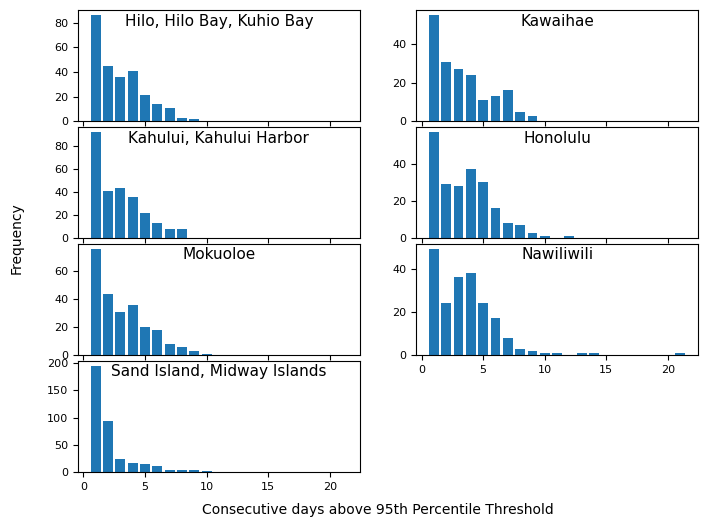

In [4]:
 # Get histogram of events for all years for each station
event_counts = {station: [] for station in station_names}


# Plot histograms using subplots
fig, axes = plt.subplots(4,2, figsize=(8,6), gridspec_kw={'hspace': 0.05})  # Adjusted to 4x2 grid with minimal vertical space

max_event_length = max([e['length'] for events in flood_events.values() for e in events], default=0)

for i, (station, events) in enumerate(flood_events.items()):
    event_lengths = [e['length'] for e in events]
    ax = axes[i // 2, i % 2]
    ax.hist(event_lengths, bins=range(1, max_event_length+1), align='left', rwidth=0.8)
    ax.text(0.5, 0.9, station, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=11)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Make tick labels smaller


# Set only one x-axis and one y-axis label
fig.text(0.5, 0.04, f'Consecutive days above {percentile}th Percentile Threshold', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

#remove empty subplots
axes_with_data = [ax for ax in axes.flatten() if ax.has_data()]
for ax in axes.flatten():
    if not ax.has_data():
        ax.remove()

    

Note again that consecutive days above the 95th percentile threshold means that the sea level meets or exceeds that threshold at least once per day consecutively, e.g. two consecutive higher-high tides.

### Make it interactive


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the number of rows and columns for the subplots
rows, cols = 4, 2

# Create a subplot grid with minimal spacing
fig = make_subplots(
    rows=rows, cols=cols, 
    vertical_spacing=0.01, horizontal_spacing=0.05  # Reduced spacing between subplots
)

# Plot histograms for each station
for i, (station, events) in enumerate(flood_events.items()):
    event_lengths = [e['length'] for e in events]
    row = (i // cols) + 1
    col = (i % cols) + 1
    
    # Define the hovertemplate with units
    hovertemplate = (
        "Duration: %{x} days<br>" +
        "Event Count: %{y} " +
        "<extra></extra>"
    )

    fig.add_trace(go.Histogram(
        x=event_lengths,
        xbins=dict(start=1, end=20, size=1),  # Ensure each bin corresponds to 1 day
        marker=dict(color="rgba(31, 119, 180, 0.7)", line=dict(width=1, color='rgba(31, 119, 180, 1)')),  # Blue color with transparency
        showlegend=False,
        hovertemplate=hovertemplate,
    ), row=row, col=col)
    
    # Set outline for each subplot
    fig.update_xaxes(showline=True, linewidth=0.2, linecolor='lightgrey', mirror=True, row=row, col=col,tickfont=dict(size=8),range = [1,20], matches='x')
    fig.update_yaxes(showline=True, linewidth=0.2, linecolor='lightgrey', mirror=True, row=row, col=col,tickfont=dict(size=8),)
    # fig.update_annotations(selector=dict(row=row, col=col), font=dict(size=12))  # Adjust title font size
    
    # Remove x-axis labels from all rows except the last one
    if row < rows:
        fig.update_xaxes(showticklabels=False, row=row, col=col)

    fig.add_annotation(
        text=station,
        x=0.5, y=0.87,  # Position in the top right corner
        xref="x domain",  # Reference the x-axis domain of the subplot
        yref="y domain",  # Reference the y-axis domain of the subplot
        row=row,  # Reference the x-axis domain of the subplot
        col=col,  # Reference the y-axis domain of the subplot
        showarrow=False,
        font=dict(size=10),
        xanchor='center', yanchor='top'
    )


# Add the x-axis label using an annotation and nudge it to the right
fig.add_annotation(
    text=f"Consecutive days above {percentile}th Percentile Threshold",
    x=0.5,  # Centered horizontally
    y=-0.12,  # Position it below the bottom row of subplots
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14),
    xanchor="center",  # You can change this to "left" or "right" to further adjust
)

# Add the x-axis label using an annotation and nudge it to the right
fig.add_annotation(
    text="Event Count (1983-2023)",
    y=0.5,  
    x=-0.1,  
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14),
    yanchor="middle",  # You can change this to "left" or "right" to further adjust
    textangle=-90
)



# Adjust layout to ensure a white background and reduce spacing between plots
fig.update_layout(
    height=400, width=500,  # Set the figure size
    margin=dict(t=50, b=50, l=50, r=50),  # Ensure enough space for titles and labels
    bargap=0.2,  # Increase space between bars
    plot_bgcolor='white',  # Ensure the background of the plot is white
    paper_bgcolor='white',  # Set the paper background color to white
)

# Show the interactive plot
fig.show()

#save html
fig.write_html(output_dir / 'flood_duration_histograms.html', full_html=True)

## Examine the distribution through box plots
Here we seek the answer the question: how common is it to have XX number of consecutive days above a given threshold?

In [6]:
import plotly.graph_objects as go
import seaborn as sns

# Use the Seaborn "Set1" palette
palette = sns.color_palette("Set1", n_colors=8)
colors = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.5)" for r, g, b in palette]  # 0.5 for 50% transparency

# Convert the flood_events dictionary into a format suitable for Plotly
data = []

for color, (station, events) in zip(colors, flood_events.items()):
    event_lengths = [e['length'] for e in events]
    data.append(go.Box(
        y=event_lengths,
        name=station,
        boxmean=True,  # To show the mean line
        boxpoints='outliers',  # Show only outliers as points
        line=dict(width=2, color=color.replace("0.5", "1")),  # Use solid color for the box outline
        fillcolor=color,  # Use the Seaborn color with transparency
        marker=dict(color=color.replace("0.5", "1"))  # Use solid color for markers
    ))

# Create the figure
fig = go.Figure(data=data)

# Update layout
fig.update_layout(
    
    title="Distribution of Flood Event Lengths by Station",
    yaxis_title=f"Consecutive Days Above <br>{percentile}th Percentile Threshold",
    xaxis_title="Station",
    xaxis_tickangle=-45,  # Rotate station names
    template="plotly_white",  # Use a white background template for clarity
    width=700, height=700  # Set the figure size
)

# Show the interactive plot
fig.show()


## Make a map

Here we'll make an interactive map of average duration of exceedance (time above flood threshold level) for all of our tide gauges. What this tells us: how long should we expect it to be "flooded," given an exceedance water level. In the Hawaiian Island region, most of this will be purely tidally based, and you would not expect "flooding" to occur beyond a tidal cycle (in terms of hours exceeded). In other locations that might experience prolonged flooding from seasonal water cycles or storm surge (for example), these statistics would look completely different.  

The following function will return a data array of height above threshold and duration for a given hourly water level record(s) and threshold level. 

In [7]:
def get_flood_ds(hourly_data, threshold=30):
    flood_hour = (hourly_data.sea_level_MHHW.values > threshold)
    flood_hour
    flood_hour = np.transpose(flood_hour)
    flood_hour_df = pd.DataFrame(flood_hour, index = hourly_data.time.values, columns = hourly_data.station_id.values)

    # get sea level data where flood_hour is Truerec

    flood_data = hourly_data.sea_level_MHHW.where(flood_hour.T)
    flood_data_df = pd.DataFrame(flood_data.T-threshold, index = hourly_data.time.values, columns = hourly_data.station_id.values)

    # Find indices of flood events, and the duration of each event for record id = 57
    # Initialize a dictionary to store the durations
    flood_durations = {}
    flood_heights = {}


    df_flood = flood_hour_df 

    # Loop through each sensor column
    for column in flood_hour_df.columns:
        flood_durations[column] = []
        flood_heights[column] = []

        # Find the indices where flooding starts and ends
        flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()

        # Group by the flood event indices, filtering out False events
        for event_id, group in df_flood.groupby(flood_events):
            if group[column].iloc[0]:  # Only consider True (flood) events
                start_time = group.index.min()
                end_time = group.index.max()
                duration = end_time - start_time 
                # round to nearest hour
                duration = np.round(duration.total_seconds() / 3600) + 1
                flood_durations[column].append((start_time, duration))
                height = flood_data_df.loc[start_time:end_time, column].max() # max height
                flood_heights[column].append((start_time, height))

    # make dataframe from dictionary
    # Assuming flood_durations and hourly_data are already defined

    # Initialize an empty list to store DataArrays
    data_arrays = []

    # Loop through each station_id and create a DataArray
    for station_id in hourly_data.station_id.values:

        if len(flood_durations[station_id]) == 0 or len(flood_heights[station_id]) == 0:
            continue

        flood_durations_df = pd.DataFrame(flood_durations[station_id])
        flood_durations_df.columns = ['time', 'duration']

        flood_heights_df = pd.DataFrame(flood_heights[station_id])   
        flood_heights_df.columns = ['time', 'height']

        # Merge the two DataFrames on 'time'
        merged_df = pd.merge(flood_durations_df, flood_heights_df, on='time', how='inner')

        # Create a DataArray with both 'duration' and 'height'
        flood_data_da = xr.DataArray(
            merged_df[['duration', 'height']].values,
            dims=['time', 'variable'],
            coords={'time': merged_df.time.values, 'variable': ['duration', 'height'], 'station_id': station_id}
        )

        data_arrays.append(flood_data_da)


    # Combine all DataArrays into a single Dataset
    flood_data_ds = xr.concat(data_arrays, dim='station_id', join='outer')

    # Convert to Dataset
    flood_data_ds = flood_data_ds.to_dataset(dim='variable')

    # make storm time by shifting time by 4 months, such that May 1st is the start of the storm season
    # Convert the time values to pandas DatetimeIndex
    time_values = pd.to_datetime(flood_data_ds.time.values)
    
    # Jan 1 should be the equivalent of May 1
    shifted_time_values = time_values + pd.DateOffset(months=4)
    
    #remove anything in 1982
    shifted_time_values = shifted_time_values[shifted_time_values.year != 1982]
    
    
    # Assign the shifted time values back to the dataset
    flood_data_ds['time'] = shifted_time_values

    return flood_data_ds

In [8]:
hourly_data = xr.open_dataset(data_dir / 'SL_hourly_data.nc',decode_timedelta=True)

Now for each threshold level from 15cm to 60m above MHHW, we'll look at the average duration and average height above that threshold. 

In [9]:
average_duration = {}
average_height = {}
threshold_levels = np.arange(15,60,5)

for i in range(len(threshold_levels)):
    level = threshold_levels[i]
    flood_data = get_flood_ds(hourly_data, threshold=level)
    average_duration[level] = flood_data['duration'].mean(axis=1)
    average_height[level] = flood_data['height'].mean(axis=1)

And now we'll make an interactive plot.

In [10]:
SL_daily_max

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 15341, station_id: 7)
Coordinates:
  * station_id      (station_id) int64 56B 1617760 1617433 ... 1611400 1619910
  * time            (time) datetime64[ns] 123kB 1983-01-01 ... 2024-12-31
Data variables: (12/14)
    sea_level       (time, station_id) float64 859kB ...
    sea_level_MHHW  (time, station_id) float64 859kB ...
    day             (time) int64 123kB ...
    month           (time) int64 123kB ...
    year            (time) int64 123kB ...
    year_storm      (time) int64 123kB ...
    ...              ...
    station_name    (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'S...
    MHHW            (station_id) float64 56B ...
    MSL             (station_id) float64 56B ...
    MLLW            (station_id) float64 56B ...
    flood_day       (time, station_id) bool 107kB ...
    threshold       (station_id) float64 56B ...

In [11]:
import plotly.express as px
import pandas as pd

# ---- Build station name lookup ----
station_ids = SL_daily_max['station_id'].values
station_names = SL_daily_max['station_name'].values
station_names_dict = dict(zip(station_ids, station_names))

# ---- Build a DataFrame per threshold (only valid stations) ----
dfs = {}
for level in threshold_levels:
    valid_station_ids = average_duration[level].station_id.values
    avg_durations = average_duration[level].values

    # Vectorized lat/lon pulls from xarray
    lats = SL_daily_max['lat'].sel(station_id=valid_station_ids).values
    lons = SL_daily_max['lon'].sel(station_id=valid_station_ids).values

    dfs[level] = pd.DataFrame({
        'Station': [station_names_dict[s] for s in valid_station_ids],
        'Latitude': lats,
        'Longitude': lons,
        'AvgDuration': pd.Series(avg_durations).round(1)
    })

# ---- Initial figure ----
initial_level = threshold_levels[0]
df0 = dfs[initial_level]

fig = px.scatter_map(
    df0,
    lat="Latitude",
    lon="Longitude",
    color="AvgDuration",
    size="AvgDuration",
    hover_name="Station",
    color_continuous_scale="Viridis",
    zoom=3.2,
    height=300,
    width=500,
)
# Map style (requires a Mapbox token if not using "open-street-map")
fig.update_layout(
    map_style="carto-positron",
    coloraxis_colorbar = dict(title=None,tickfont=dict(family='Avenir, Helvetica, Arial, sans-serif')))
fig.update_traces(
    text=df0["Station"],  # pass station names into text
    hovertemplate="<b>%{text}</b><br>Avg Duration: %{marker.color} hours<extra></extra>"
)

# ---- Dropdown: update all arrays when threshold changes ----
dropdown_buttons = []
for level in threshold_levels:
    df = dfs[level]
    dropdown_buttons.append(
        dict(
            label=f"{level} cm",
            method="restyle",
            args=[
                {
                    "lat":   [df["Latitude"]],
                    "lon":   [df["Longitude"]],
                    "marker.color": [df["AvgDuration"]],
                    "marker.size":  [df["AvgDuration"]],
                    "text":         [df["Station"]],
                    "hovertemplate": [
                        "<b>%{text}</b><br>Avg Duration: %{marker.color} hours<extra></extra>"
                    ],
                }
            ],
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.01, xanchor="left",
            y=0.995, yanchor="top",
            pad = dict(l=10,r = 18,b=8,t=8),
            borderwidth=0,
        )
    ],
    margin=dict(r=90, t=110, l=0, b=0),
    title_text="Average Duration of Exceedance",
    title_x=0.01
)

# ---- Subtitle ----
fig.add_annotation(
    text="(Select threshold from dropdown to update map)",
    x=0.3, y=0.95,xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=11, color="gray", family="Avenir, Helvetica, Arial, sans-serif"),
    xanchor="left"
)

# ---- Vertical colorbar label via annotation ----

# 1) Ensure there's space on the right so the label isn't clipped
fig.update_layout(margin=dict(r=110, t=40, l=0, b=0))

# 2) Hide built-in title
fig.update_layout(coloraxis_colorbar=dict(title=None))

# 3) Add vertical label as an annotation
fig.add_annotation(
    text="Avg Duration (hours)",
    xref="paper", yref="paper",
    x=1.07, y=0.5,                # on the right edge of plot area
    xshift=45,                   # nudge outward toward the colorbar
    showarrow=False,
    textangle=90,
    font=dict(family="Avenir, Helvetica, Arial, sans-serif", size=14, color="black"),
    xanchor="left", yanchor="middle"
)

# ---- Global font ----
fig.update_layout(
    font=dict(
        family="Avenir, Helvetica, Arial, sans-serif",
        size=14,
        color="black"
    )
)

# ---- Center Map ------

mid_lat = SL_daily_max['lat'].values.min() + (SL_daily_max['lat'].values.max()-SL_daily_max['lat'].values.min())/2
mid_lon = SL_daily_max['lon'].values.min() + (SL_daily_max['lon'].values.max()-SL_daily_max['lon'].values.min())/2
fig.update_layout(
    map_center=dict(lat=mid_lat, lon=mid_lon)
    )



fig.show()

# save as html
fig.write_html(output_dir / 'avg_flood_duration_map.html', full_html=False, include_plotlyjs='cdn')

If the interactive plot is not working above, here it is in an iframe. In future versions of JupyterBook this problem will hopefully be addressed.
<iframe src="https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/avg_flood_duration_map.html" width="100%" height=500px frameborder="0" title="Average Flood Duration Map"></iframe>